In [1]:
from typing import NamedTuple

import botorch
import gpytorch
import torch

from utils.training import fit_gp_model
from utils.plots import visualize_gp_belief_and_policy

%load_ext autoreload
%autoreload 2

/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def forrester_1d(x):
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [3]:
bound = 5
xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

In [4]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
train_x = torch.tensor([[1.], [2.]])
train_y = forrester_1d(train_x)

In [6]:
class GPData(NamedTuple):
    train_x: torch.Tensor
    train_y: torch.Tensor
    xs: torch.Tensor
    ys: torch.Tensor

In [7]:
data = GPData(train_x, train_y, xs, ys)

iteration: 0
incumbent: tensor([1.]), obj. func. value: 1.6054


100%|██████████| 500/500 [00:00<00:00, 1313.16it/s]


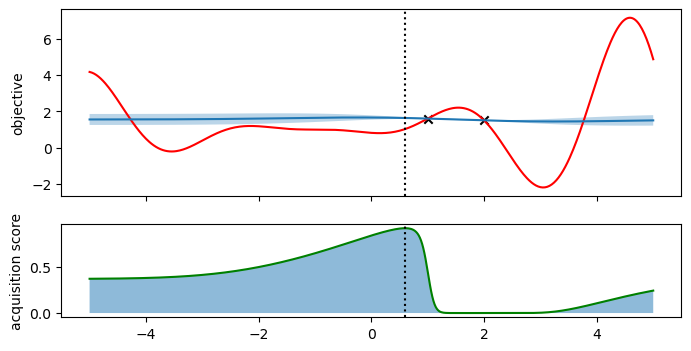

iteration: 1
incumbent: tensor([1.]), obj. func. value: 1.6054


100%|██████████| 500/500 [00:00<00:00, 1404.41it/s]


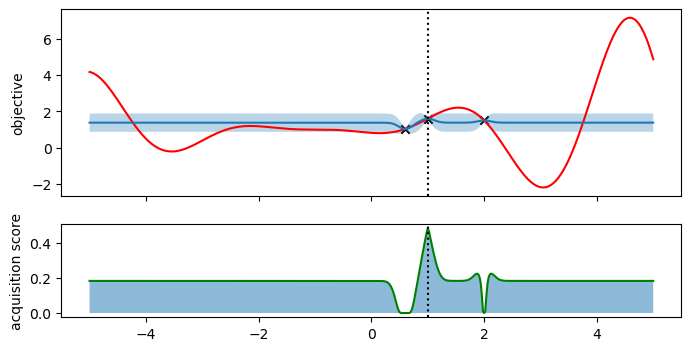

iteration: 2
incumbent: tensor([1.0036]), obj. func. value: 1.6115


100%|██████████| 500/500 [00:00<00:00, 1365.71it/s]


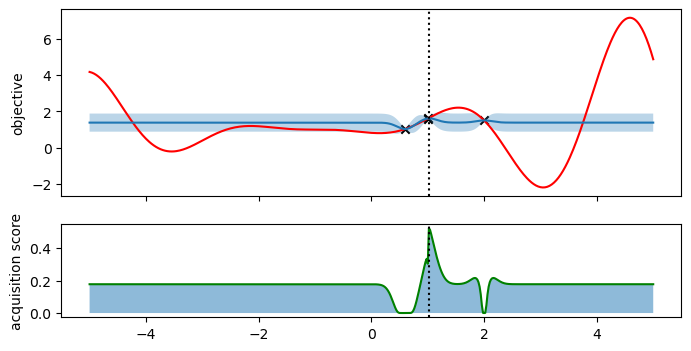

iteration: 3
incumbent: tensor([1.0240]), obj. func. value: 1.6450


100%|██████████| 500/500 [00:00<00:00, 1202.74it/s]


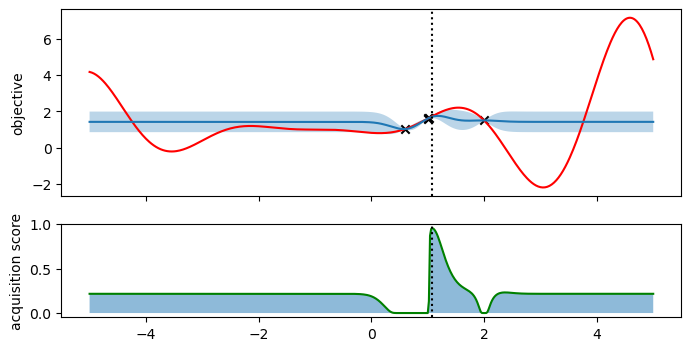

iteration: 4
incumbent: tensor([1.0792]), obj. func. value: 1.7353


100%|██████████| 500/500 [00:00<00:00, 1172.10it/s]


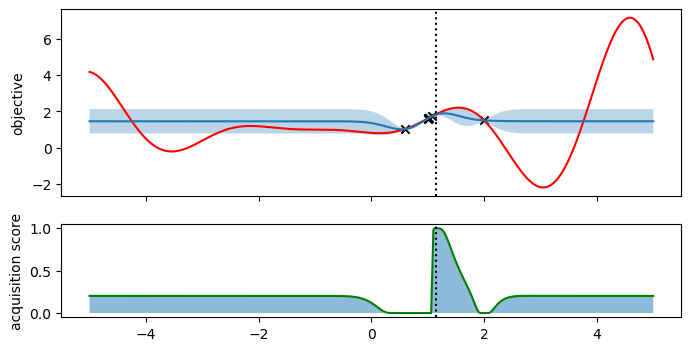

iteration: 5
incumbent: tensor([1.1455]), obj. func. value: 1.8401


100%|██████████| 500/500 [00:00<00:00, 1129.38it/s]


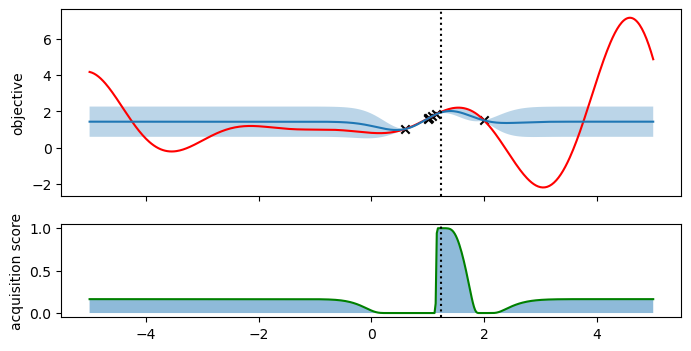

iteration: 6
incumbent: tensor([1.2286]), obj. func. value: 1.9612


100%|██████████| 500/500 [00:00<00:00, 1129.14it/s]


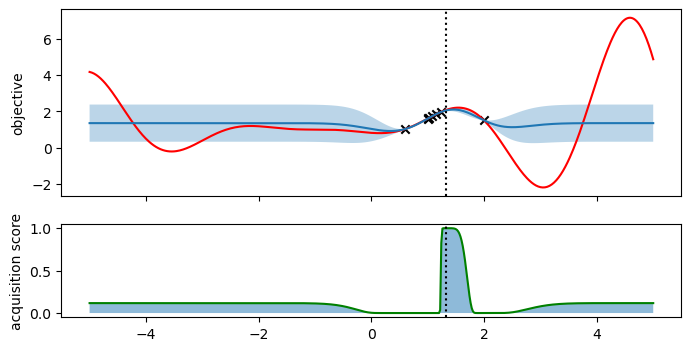

iteration: 7
incumbent: tensor([1.3240]), obj. func. value: 2.0780


100%|██████████| 500/500 [00:00<00:00, 1066.94it/s]


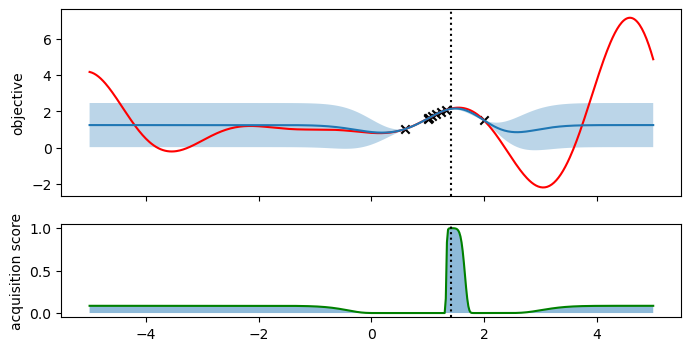

iteration: 8
incumbent: tensor([1.4205]), obj. func. value: 2.1621


100%|██████████| 500/500 [00:00<00:00, 1015.73it/s]
/Users/gabestechschulte/miniforge3/envs/bayesopt/lib/python3.11/site-packages/botorch/optim/optimize.py:359: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  warnings.warn(first_warn_msg, RuntimeWarning)


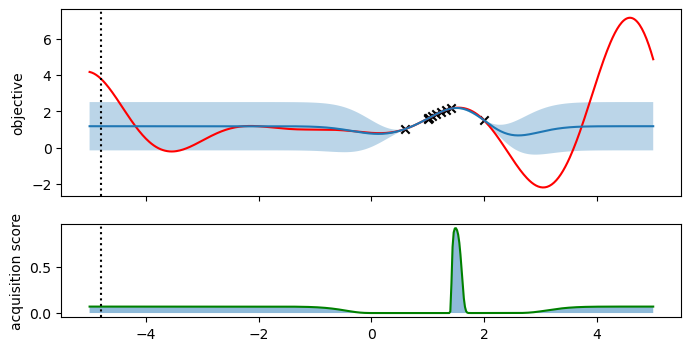

iteration: 9
incumbent: tensor([-4.8027]), obj. func. value: 3.8031


100%|██████████| 500/500 [00:00<00:00, 1170.78it/s]


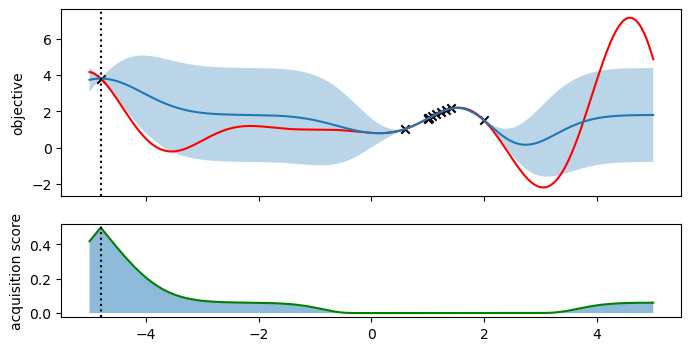

In [8]:
num_queries = 10
for i in range(num_queries):
    print(f"iteration: {i}")
    print(f"incumbent: {train_x[train_y.argmax()]}, obj. func. value: {train_y.max():.4f}")

    data = GPData(train_x, train_y, xs, ys)

    # run training loop to fit the GP
    model, likelihood = fit_gp_model(GPModel, data)

    # compute acquisition scores and get next point
    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    next_x, acq_score = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50
    )
    
    # visualization
    visualize_gp_belief_and_policy(model, likelihood, data, policy, next_x)
    
    # evaluate obj. func. at next_x and update training data
    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])